In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import linalg as LA
import pickle
import random

In [13]:
##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100


k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])

In [84]:
with open("variables_eigen.pickle", "rb") as f:
    R_final, U_final, U_noise, C_noise = pickle.load(f)

In [105]:
dt = 0.001
T = 200
t = np.linspace(0,T,int(T/dt)+1)

C = np.zeros((4,4,len(t)))

Q = np.zeros((4,4))
Q[0, 0] = 8 / (k_e**2)

epsilon = 0.01
r_m = 0.1

U = np.zeros((len(t)))
R = np.zeros((len(t)))

C[:,:,0] = 0
U[0] = 0.001

for i in range(0,len(t)-1):

    A = W + U[i]*L

    noise_forcing = epsilon * Q * 1800 * np.random.normal(0, 1)

    R[i+1] = C[0,2,i]*(0.25 * k * ((k_plus**2) - (k_e**2)))

    C[:,:,i+1] = C[:,:,i]+ dt*(A @ C[:,:,i]  + C[:,:,i] @ A.T + epsilon * Q + noise_forcing * np.sqrt(dt))

    U[i+1] = U[i] + dt*(-r_m*U[i]+R[i])


In [106]:
# Find the index corresponding to time t=100
start_index = int((T/2) / dt) 

# Slice arrays starting from the index of t=100
t = t[start_index:]
t = t - t[0]
C = C[:,:, start_index:]
U = U[start_index:]
R = R[start_index:]

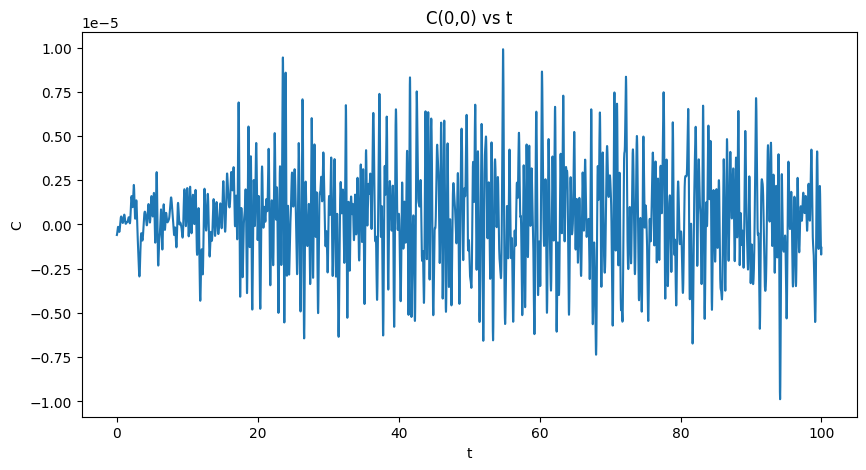

In [107]:
plt.figure(figsize=(10, 5))
plt.plot(t,C[0,2], '-')
plt.xlabel('t')
plt.ylabel('C')
plt.title('C(0,0) vs t')
plt.show()

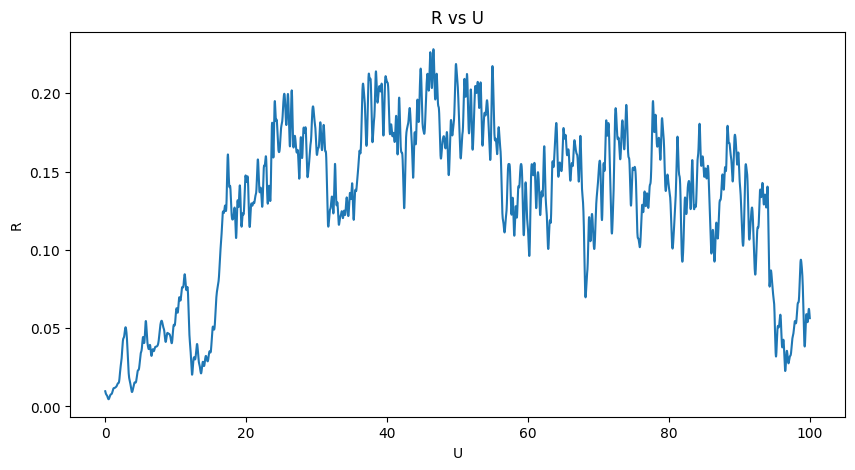

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(t,U, '-')
plt.xlabel('U')
plt.ylabel('R')
plt.title('R vs U')
plt.show()

In [109]:
U_final = U[-1,]
C_final = C[:,:,-1]

R_final = 0.25 * k * (k_plus**2 - k_e**2) * C_final[0,2]

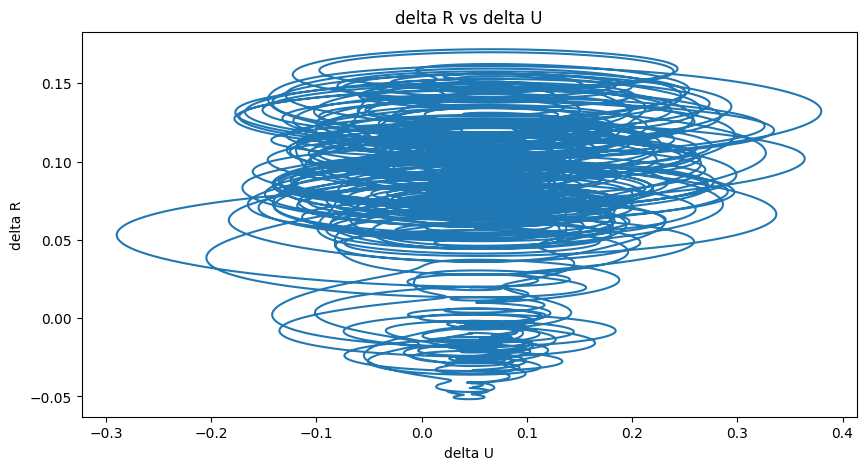

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(R-R_final,U-U_final, '-')
plt.xlabel('delta U')
plt.ylabel('delta R')
plt.title('delta R vs delta U')
plt.show()

In [111]:
# Define the number of bins
num_bins = 10

# Define the bins for U
u_bins = np.linspace(U.min(), U.max(), num_bins)

r_bins = np.linspace(R.min(), -R.min(), 50)

# Compute the 2D histogram of R and U
hist, u_edges, r_edges = np.histogram2d(U, R, bins=[u_bins, r_bins], density=True)

# Compute the conditional probability P(R|U) by normalizing each U bin by its total count
p_r_given_u = hist / np.sum(hist, axis=1, keepdims=True)


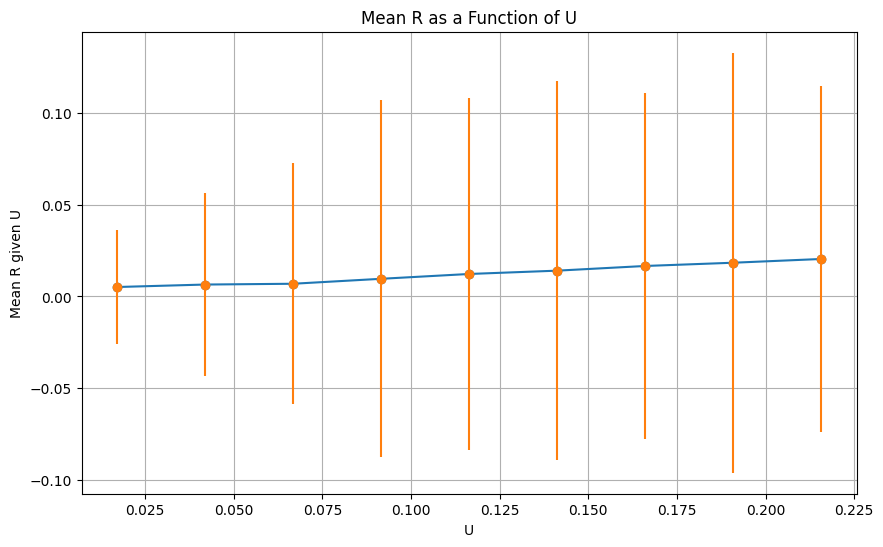

In [112]:
# First, compute the center of each R bin
r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

# Initialize an array to store the mean R for each U bin
mean_R_given_U = np.zeros(p_r_given_u.shape[0])
std_R_given_U = np.zeros(p_r_given_u.shape[0])

# Loop over each U bin
for i in range(p_r_given_u.shape[0]):
    
    # Compute the weighted average of R for this U bin
    mean_R_given_U[i] = np.sum(r_centers * p_r_given_u[i,:])
    std_R_given_U[i] = np.sqrt(np.sum((r_centers - mean_R_given_U[i])**2 * p_r_given_u[i,:]))

# Now, compute the center of each U bin
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])

# Plot mean R as a function of U
plt.figure(figsize=(10,6))
plt.plot(u_centers, mean_R_given_U ,'-', marker='o')
# plot the error bars (1 standard deviation)
plt.errorbar(u_centers, mean_R_given_U, yerr=std_R_given_U, fmt='o')
plt.xlabel('U')
plt.ylabel('Mean R given U')
plt.title('Mean R as a Function of U')
plt.grid(True)
plt.show()

In [113]:
# Binning the U values
U_bin_number = np.digitize(U, u_bins)

# Initialize empty arrays to store the R values for each U bin
R_values_in_bins = [[] for _ in range(num_bins)]

# Loop over the U and R data
for i in range(len(U)):
    
    # Get the bin number for this U value
    bin_number = U_bin_number[i] - 1  # subtract 1 because np.digitize bins are 1-indexed
    if bin_number==9:
        bin_number=8
    
    # Append the corresponding R value to the appropriate bin
    if bin_number < num_bins:  # ignore U values that fall in the overflow bin
        R_values_in_bins[bin_number].append(R[i])

# Now you have lists of R values for each U bin
# You could convert these lists to numpy arrays if you want to perform numpy operations on them
R_values_in_bins = [np.array(bin_values) for bin_values in R_values_in_bins]

In [114]:
R_values_in_bins = R_values_in_bins[0:9]

In [115]:
R_mean_in_bins = np.zeros(len(R_values_in_bins))
R_std_in_bins = np.zeros(len(R_values_in_bins))
R_sem_in_bins = np.zeros(len(R_values_in_bins))
R_var_in_bins = np.zeros(len(R_values_in_bins))

for i in range(len(R_mean_in_bins)):

    R_mean_in_bins[i] = np.mean(R_values_in_bins[i])
    R_std_in_bins[i] = np.std(R_values_in_bins[i])
    R_sem_in_bins[i] = R_std_in_bins[i]/np.sqrt(len(R_values_in_bins[i]))
    R_var_in_bins[i] = R_std_in_bins[i]**2

print(R_mean_in_bins)
print(R_std_in_bins)
print(R_sem_in_bins)
print(R_var_in_bins)

[0.00524261 0.00647755 0.00709354 0.0095745  0.01215849 0.0140597
 0.01666662 0.01873977 0.02048671]
[0.03059601 0.04993036 0.06553827 0.09714145 0.09588509 0.10305422
 0.09435442 0.11478413 0.09422258]
[0.00040331 0.00047853 0.0009878  0.00157854 0.00078108 0.00071826
 0.00061969 0.00105037 0.00142224]
[0.00093612 0.00249304 0.00429527 0.00943646 0.00919395 0.01062017
 0.00890276 0.0131754  0.00887789]


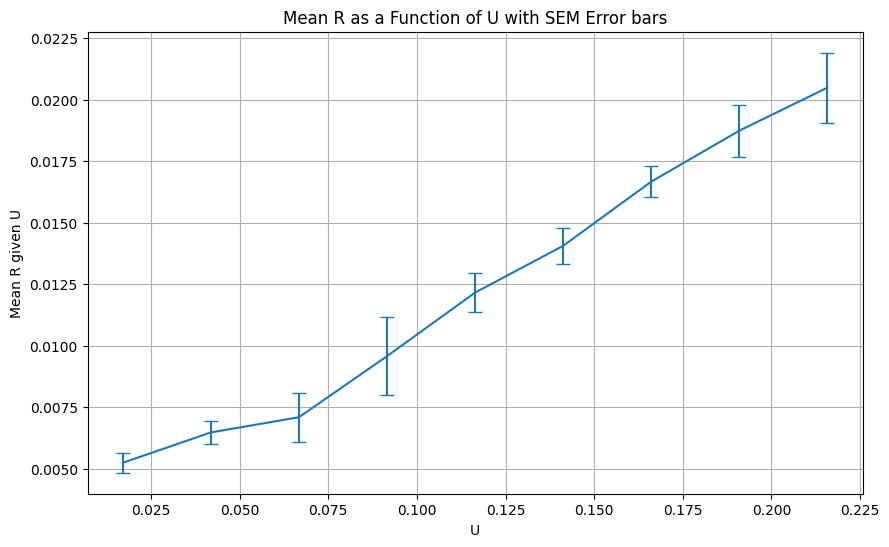

In [116]:
plt.figure(figsize=(10,6))
plt.errorbar(u_centers, R_mean_in_bins, yerr=R_sem_in_bins, fmt='-', capsize=5)
plt.xlabel('U')
plt.ylabel('Mean R given U')
plt.title('Mean R as a Function of U with SEM Error bars')
plt.grid(True)
plt.show()

In [118]:
(R_mean_in_bins[8]-R_mean_in_bins[4])/(u_centers[8]-u_centers[4])

0.08382312103908082